In [66]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys
import networkx as nx
import warnings
import matplotlib.cbook
# from joyflo import reactflow_to_networkx

In [67]:
import sys
dir_path = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(dir_path, os.pardir)))

In [68]:
print(os.getcwd())

/home/sifat/Workspace/flojoy-desktop/PYTHON/WATCH


In [69]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *
from FUNCTIONS.COMPARATORS import *

In [70]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

#### *Configuring Redis*

In [71]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r)

In [72]:
# Load React flow chart object from JSON file

f = open('./test-fc.json')
fc = json.loads(f.read())
elems = fc['elements']

#### *Configuring NETWORKX*

In [73]:
DG = nx.DiGraph()
DG.clear()

#### *Converting the elements to nodes*

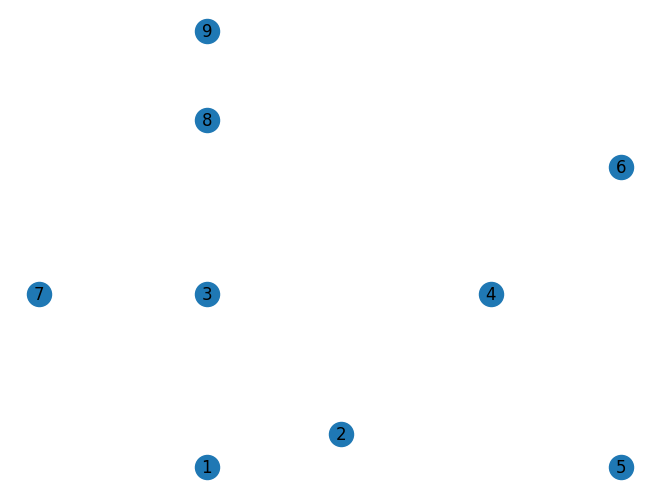

In [74]:
for i in range(len(elems)):
    el = elems[i]
    if 'source' not in el:
        data = el['data']
        ctrls = data['ctrls'] if 'ctrls' in data else {}
        DG.add_node(i+1, pos=(el['position']['x'], el['position']['y']), id=el['id'], ctrls=ctrls)
        elems[i]['index'] = i+1
        elems[i]['label'] = el['id'].split('-')[0]

pos = nx.get_node_attributes(DG,'pos')
nx.draw(DG, pos, with_labels=True)

#### *Adding Edges*

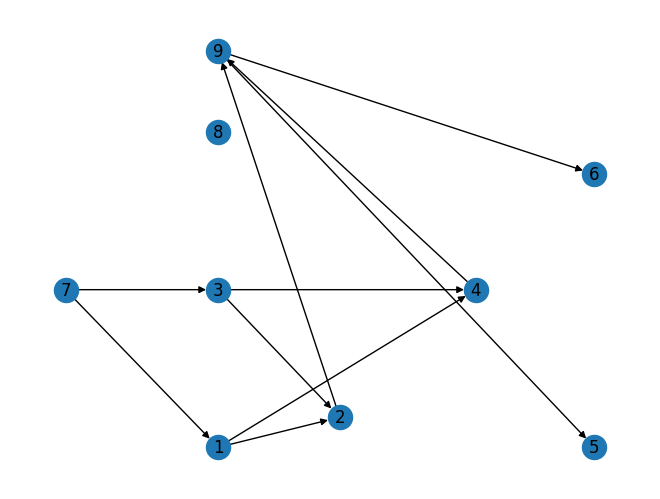

In [75]:
edge_label_dict = {}
def get_tuple(edge):
    e = [-1, -1]
    src_id = edge['source']
    tgt_id = edge['target']

    type = edge['type']
    if type == 'special':
        label = edge['label']
    else:
        label = 'default'
    if tgt_id not in edge_label_dict.keys():
        edge_label_dict[tgt_id] = []
    edge_label_dict[tgt_id].append({
        'source': src_id,
        'label':label
    })

    # iterate through all nodes looking for matching edge
    for el in elems:
        if 'id' in el:
            if el['id'] == src_id:
                e[0] = el['index']
            elif el['id'] == tgt_id:
                e[1] = el['index']
    return tuple(e)

for i in range(len(elems)):
    el = elems[i]
    if 'source' in el:
        # element is an edge
        e = get_tuple(el)
        DG.add_edge(*e)
nx.draw(DG, pos, with_labels=True)
# print(edge_label_dict)

#### *Adding Labels to each nodes*

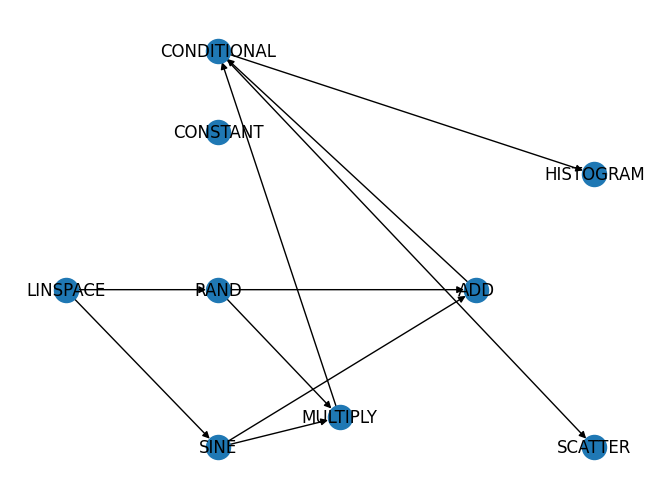

In [76]:
labels = {}
type = {}

for el in elems:
    # if element is not a node
    if 'source' not in el:
        labels[el['index']] = el['data']['label']
        type[el['index']] = el['type']
                
nx.set_node_attributes(DG, labels, 'cmd')
nx.set_node_attributes(DG, type,'type')
nx.draw(DG, pos, with_labels=True, labels = labels)

#### *UTIL FUNCTIONS*

In [77]:
def get_node_data_by_id():
    nodes_by_id = dict()
    for n, nd in DG.nodes().items():
        nodes_by_id[n] = nd
    return nodes_by_id

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

topological_sorting = nx.topological_sort(DG)
nodes_by_id = get_node_data_by_id()

#### TESTING THE CONSTRUCTED GRAPH

In [78]:
for n, nd in DG.nodes().items():
    print('node', n, 'node data', nd)

for node in nx.topological_sort(DG):
    print(node)

node 1 node data {'pos': (291, 105), 'id': 'SINE-userGeneratedNode_1646417316016', 'ctrls': {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}}, 'cmd': 'SINE', 'type': 'default'}
node 2 node data {'pos': (523, 135), 'id': 'MULTIPLY-userGeneratedNode_1646417352715', 'ctrls': {}, 'cmd': 'MULTIPLY', 'type': 'default'}
node 3 node data {'pos': (291, 262), 'id': 'RAND-userGeneratedNode_1646417371398', 'ctrls': {}, 'cmd': 'RAND', 'type': 'default'}
node 4 node data {'pos': (783, 262), 'id': 'ADD-userGeneratedNode_1646417428589', 'ctrls': {}, 'cmd': 'ADD', 'type': 'default'}
node 5 node data {'pos': (1009, 105), 'id': 'SCATTER-userGeneratedNode_1646417560399', 'ctrls': {}, 'cmd': 'SCATTER', 'type': 'default'}
node 6 node data {'pos': (1009, 377), 'id': 'HISTOGRAM-userGeneratedNode_1646417604301'

In [79]:
'''
    @func wait_for_special_type_job_to_finish
    description: Waits for special type node like conditional to finish, so that the code flow is in the right direction.
'''

def wait_for_special_type_job_to_finish(n):
   
    job_id = jid(n)
    job = None
    try:
        job = Job.fetch(job_id, connection=r)
        nd = nodes_by_id[n]
    except Exception:
        print(traceback.format_exc())

    job_status,is_node_failed,attempt_count = None,False,0

    while True:
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        attempt_count += 1
        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        
        if job_status == 'finished':
            is_node_failed = False
            break

        if is_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break

        if job_status == 'failed':
            is_node_failed = True
            break

        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)
    print("IS ANY NODE FAILED ",is_node_failed)
    return True if not is_node_failed else False

In [80]:
'''
    TODO all types of registries, deferred, failed, finished.
'''

def handle_special_type_node(node_serial,node_label):

    if node_label == "CONDITIONAL":
        status = check_predecessor(node_serial)
        return status   
        

In [81]:
def find_edge_label(source_id,destination_id):
    for key, value in edge_label_dict.items():
        if key == destination_id:
            for ind_value in value:
                if ind_value['source'] == source_id:
                    return ind_value['label']
    return None

In [82]:
def is_eligible_to_enqueue(node_serial,enqued_jobs_list):
    
    '''
        TODO Check Predecessor:
             - IF any Predecessor is special type, then check edge label, if both true, then pass the 
    '''

    previous_job_ids = []
    is_eligible = True
    for p in DG.predecessors(node_serial):
        type = nodes_by_id[p]['type']
        job_id = jid(p)
        if type == 'special':

            '''
                TODO: check if the predecessor result is ready.
            '''

            status = wait_for_special_type_job_to_finish(p)
            print()
            if not status:
                return False,[]

            job = Job.fetch(job_id, connection=r)
            result = job.result

            flow_direction = result['direction']

            source_id = nodes_by_id[p]['id']
            destination_id = nodes_by_id[node_serial]['id']
            label = find_edge_label(source_id,destination_id)

            if (flow_direction is not None) and (label != flow_direction):
                return False,[]
            previous_job_ids.append(job_id)
        else:

            if job_id not in enqued_jobs_list:
                return False,[]
            else:
                previous_job_ids.append(job_id)
                
    return is_eligible,previous_job_ids

In [83]:
print(globals()['CONDITIONAL'])

func = getattr(globals()['CONDITIONAL'],'CONDITIONAL')
print(func)

<module 'FUNCTIONS.COMPARATORS.CONDITIONAL' from '/home/sifat/Workspace/flojoy-desktop/PYTHON/FUNCTIONS/COMPARATORS/CONDITIONAL.py'>
<function CONDITIONAL at 0x7f41946ffc10>


In [84]:
total_enqued_node = 0
enqued_jobs_list = []
is_eligible_to_enqued = True
special_type_node_payload = None
flow_direction = None
is_special_type_node_enqueued = False

for n in nx.topological_sort(DG):
    cmd,ctrls,type = get_node_data_by_id()[n]['cmd'],get_node_data_by_id()[n]['ctrls'],get_node_data_by_id()[n]['type']
    
    job_id = jid(n)
    func = getattr(globals()[cmd], cmd)
    print(func)
    s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
    r.set('SYSTEM_STATUS', s)

    '''
        TODO: MUST CHECK PREDECESSORS IF ANYONE OF THEM IS SPECIAL TYPE NODES OR NOT
              IF IT'S A SPECIAL TYPE NODE, THEN WAIT FOR THE NODE RESULT.
              AND COMPARE THE NODE OUTPUT & LABEL.
    '''

    if len(list(DG.predecessors(n))) == 0:
        # print('{0} ({1}) has no predecessors'.format(cmd, n))
        q.enqueue(func,
            retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
            job_timeout='3m',
            on_failure=report_failure,
            job_id = job_id,
            kwargs={'ctrls': ctrls},
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls)
        enqued_jobs_list.append(job_id)
    else:
        is_eligible,previous_job_ids = is_eligible_to_enqueue(node_serial=n,enqued_jobs_list=enqued_jobs_list)
        # if is_special_type_node_enqueued:
        #     status = check_predecessor(n)
        #     if status:
                
        #         result = check_eligibity_collect_result(node_serial=n,flow_direction=flow_direction,enqued_jobs_list = enqued_jobs_list)
        #         is_eligible,previous_job_ids = result['is_eligible'],result['predecessor']

        #         # print(special_type_node_payload)
        print(is_eligible)
        if is_eligible:
            q.enqueue(func,
                retry=Retry(max=100),
                job_timeout='3m',
                on_failure=report_failure,
                job_id=job_id,
                kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids},
                depends_on=previous_job_ids,
                result_ttl=500)
            print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)
            enqued_jobs_list.append(job_id)
        

<function LINSPACE at 0x7f41946f35e0>
ENQUEUING... LINSPACE JOB_ID_7 {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}
<function CONSTANT at 0x7f41946f3430>
ENQUEUING... CONSTANT JOB_ID_8 {'CONSTANT_2.0_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}, 'CONSTANT_8_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}}
<function SINE at 0x7f41d805a820>
True
ENQUEUING... SINE JOB_ID_1 {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}} ['JOB_ID_7']
<function RAND at 0x7f41a0d3d430>
True
ENQUEUING... RAND JOB_ID_3 {} ['JOB_ID_7']
<function ADD at

In [85]:
for job_id in enqued_jobs_list:
    try:
        print(job_id)
        job = Job.fetch(job_id, connection=r)
        job_status = job.get_status(refresh=True)
        result = job.result
        print(job.kwargs)
        print('Status: %s' % job_status)
        # print(result)
    except Exception:
        print(job_id)
        print("no such jobs")

JOB_ID_7
{'ctrls': {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}}
Status: finished
JOB_ID_8
{'ctrls': {'CONSTANT_2.0_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}, 'CONSTANT_8_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}}}
Status: finished
JOB_ID_1
{'ctrls': {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}}, 'previous_job_ids': ['JOB_ID_7']}
Status: finished
JOB_ID_3
{'ctrls': {}, 'previous_job_ids': ['JOB_ID_7']}
Status: finished
JOB_ID_4
{'ctrls': {}, 'previous_job_ids': ['JOB_ID_1', 'JOB_ID_3']}
Status: finished
JOB_ID_2
{

In [88]:
job = Job.fetch('JOB_ID_9', connection=r)
True if 'operator' in job.kwargs['ctrls']['CONDITIONAL_OPERATOR'] else False
# job.kwargs
# job.get_status(refresh=True)

True

In [89]:
job.fetch('JOB_ID_2',connection=r)
True if 'prev_job_id' in job.kwargs else False

False

In [91]:
job.kwargs['prev_job_result'] = {1,2,3,4,5}
job.kwargs

{'ctrls': {'CONDITIONAL_OPERATOR': {'operator': 'IS_GREATER_THAN',
   'functionName': '',
   'param': '',
   'value': None}},
 'previous_job_ids': ['JOB_ID_4', 'JOB_ID_2'],
 'prev_job_id': {1, 2, 3, 4, 5},
 'prev_job_result': {1, 2, 3, 4, 5}}

In [21]:
try:
    job = Job.fetch('JOB_ID_4', connection=r)
    job_status= job.get_status(refresh=True)
    print('Status: %s' % job_status)
except Exception:
    print("no such jobs")

Status: finished


In [22]:
registry = q.failed_job_registry
print(registry.get_job_ids())

['JOB_ID_9']


In [23]:
all_node_results = []
topological_sorting = nx.topological_sort(DG)

print('\n\n')
print("Getting Node Outputs")

is_any_node_failed = False
for n in topological_sorting:
    job_id = jid(n)
    nd = nodes_by_id[n]
    # TODO have to investigate if and why this fails sometime
    # best is to remove this try catch, so we will have to come back to it soon
    try:
        job = Job.fetch(job_id, connection=r)
    except Exception:
        print(traceback.format_exc())
    job_status, redis_payload, attempt_count = None, None, 0
    while True: # or change it to wait for maximum amount of time, then we can declare job timed out
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        redis_payload = job.result
        attempt_count += 1

        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        if attempt_count > 9:
            job.delete()
            break
        if job_status == 'finished':
            break
        if is_any_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break
        if job_status == 'failed':
            is_any_node_failed = True
            break
        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)

    all_node_results.append({'cmd': nd['cmd'], 'id': nd['id'], 'result':redis_payload, 'job_status': job_status})
# print(all_node_results)




Getting Node Outputs
Job status: LINSPACE finished origin: flojoy attempt: 1
Job status: CONSTANT finished origin: flojoy attempt: 1
Job status: SINE finished origin: flojoy attempt: 1
Job status: RAND finished origin: flojoy attempt: 1
Job status: ADD finished origin: flojoy attempt: 1
Job status: MULTIPLY finished origin: flojoy attempt: 1
Job status: CONDITIONAL finished origin: flojoy attempt: 1
Traceback (most recent call last):
  File "/tmp/ipykernel_11160/1767129028.py", line 14, in <module>
    job = Job.fetch(job_id, connection=r)
  File "/home/sifat/Workspace/flojoy-desktop/venv/lib/python3.8/site-packages/rq/job.py", line 350, in fetch
    job.refresh()
  File "/home/sifat/Workspace/flojoy-desktop/venv/lib/python3.8/site-packages/rq/job.py", line 591, in refresh
    raise NoSuchJobError('No such job: {0}'.format(self.key))
rq.exceptions.NoSuchJobError: No such job: b'rq:job:JOB_ID_6'

Job status: HISTOGRAM finished origin: flojoy attempt: 1
Job status: SCATTER finished or